# LSTM vs SVM

Juan Navarro, <jsnavarroa@unal.edu.co>

-------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_path = os.path.abspath("./data")

## 1. Load dataset and preprocessing

In [95]:
import pandas as pd
from sklearn import preprocessing

dataset = pd.read_csv(data_path+"/data.csv")

dataset['Fecha corte'] = pd.DatetimeIndex(dataset['Fecha corte'])

# Normalize
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset.iloc[:, 1:] = scaler.fit_transform(dataset.iloc[:, 1:])
profit = dataset[['Rentab. dia']]

print(dataset.shape)
dataset.head()

(507, 6)


,Fecha corte,Núm. unidades,Valor unidad para las operaciones del día t,Valor fondo al cierre del día t,Núm. Invers.,Rentab. dia
0,2017-01-01,0.000000,0.000000,0.000000,0.000000,0.390802
1,2017-01-02,0.259206,0.081932,0.226349,0.058830,0.304865
2,2017-01-03,0.127319,0.160566,0.155999,0.109083,0.487156
3,2017-01-04,0.283745,0.247452,0.280241,0.155365,0.367701
4,2017-01-05,0.200984,0.322902,0.241534,0.195068,0.490302


## 2. Time series to supervised problem

In [96]:
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a DataFrame.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.size
    df = data
    cols = data.drop(data.columns[0], axis=1)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        name = 'var(t-{})'.format(i)
        cols[name] = df.shift(i)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        if i == 0:
            name = 'var(t)'
        else:
            name = 'var(t+{})'.format(i)
            
        cols[name] = df.shift(-i)
    
    # drop rows with NaN values
    if dropnan:
        cols.dropna(inplace=True)
    return cols

In [152]:
data = series_to_supervised(profit, 3, 2)

# Merge on index
data = dataset.merge(data, left_index=True, right_index=True)
data = data.drop(columns=['Rentab. dia']) # the same of var(t)

print(data.info())

data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 3 to 505
Data columns (total 10 columns):
Fecha corte                                    503 non-null datetime64[ns]
Núm. unidades                                  503 non-null float64
Valor unidad para las operaciones del día t    503 non-null float64
Valor fondo al cierre del día t                503 non-null float64
Núm. Invers.                                   503 non-null float64
var(t-3)                                       503 non-null float64
var(t-2)                                       503 non-null float64
var(t-1)                                       503 non-null float64
var(t)                                         503 non-null float64
var(t+1)                                       503 non-null float64
dtypes: datetime64[ns](1), float64(9)
memory usage: 43.2 KB
None


,Fecha corte,Núm. unidades,Valor unidad para las operaciones del día t,Valor fondo al cierre del día t,Núm. Invers.,var(t-3),var(t-2),var(t-1),var(t),var(t+1)
3,2017-01-04,0.283745,0.247452,0.280241,0.155365,0.390802,0.304865,0.487156,0.367701,0.490302
4,2017-01-05,0.200984,0.322902,0.241534,0.195068,0.304865,0.487156,0.367701,0.490302,0.271401
5,2017-01-06,0.402917,0.396767,0.401482,0.248941,0.487156,0.367701,0.490302,0.271401,0.334288
6,2017-01-07,0.390107,0.459959,0.424085,0.374089,0.367701,0.490302,0.271401,0.334288,0.264335
7,2017-01-08,0.428470,0.513253,0.524276,0.385222,0.490302,0.271401,0.334288,0.264335,0.465267


In [153]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=['Fecha corte'], errors='ignore')

features = data.shape[1]

X = data.iloc[:, 0:features-1]
y = data.iloc[:, features-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train.head()

119    0.336811
48     0.378623
19     0.363604
468    0.278645
361    0.300139
Name: var(t+1), dtype: float64

## 3. Support Vector Regression

In [164]:
from sklearn import svm
from sklearn.metrics import mean_squared_error

clf_svr = svm.SVR()
clf_svr.fit(X_train, y_train)

y_train_pred = clf_svr.predict(X_train)
y_test_pred = clf_svr.predict(X_test)

print("train score: {:0.2f}".format(clf_svr.score(X_train, y_train)))
print("test score: {:0.2f}".format(clf_svr.score(X_test, y_test)))

print("train MSE: {:0.2f}".format(mean_squared_error(y_train, y_train_pred)))
print("test MSE: {:0.2f}".format(mean_squared_error(y_test, y_test_pred)))

train score: 0.16
test score: 0.19
train MSE: 0.01
test MSE: 0.01


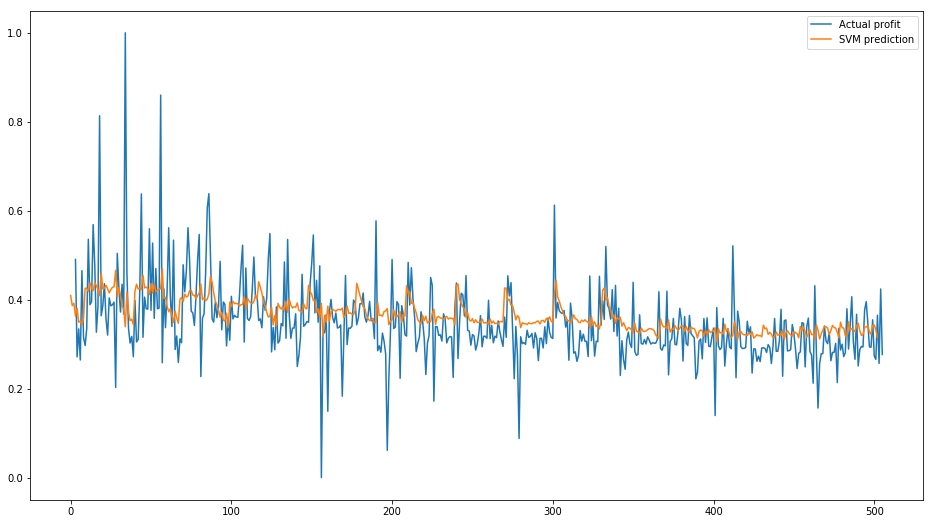

In [166]:
# Plot predictions
r, c = (1, 1)
fig, axes = plt.subplots(r, c, figsize=(16*c, 9*r))
axes = np.array(axes).reshape(-1)

ax = axes[0]
ax.plot(y, label='Actual profit')
ax.plot(clf_svr.predict(X), label='SVM prediction')
ax.legend()

plt.show()

In [6]:
data = pd.DataFrame()

    
data['t'] = report['Rentab. dia']

data['t+1'] = data['t'].shift(-1)
    

data = series_to_supervised(report['Rentab. dia'], 1)

data.head()

# Make stationary, N=1, sequence size
data = data['var(t)'] - data['var(t-1)']

# Scale for LSTM
x = data.values.reshape(-1, 1)
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaled_X = scaler.fit_transform(x)

data = pd.Series(scaled_X[:, 0])

NameError: name 'report' is not defined

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# load dataset
dataset = read_csv('/report.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
print(data.shape)
print(report['Fecha corte'].shape)

fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))
ax1.plot(report['Fecha corte'], report['Rentab. dia'])
ax1.plot(report['Fecha corte'].iloc[:data.shape[0]], data)
ax1.set_title('Daily return')
plt.show()

In [ ]:
print(data.shape)